In [1]:
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import auc, roc_curve

import warnings
warnings.filterwarnings('ignore')

def count_word_address(data):
    data['address'] = data.address.apply(lambda x: str(x).replace(',,', ''))
    data['word_count_address'] = data.address.apply(lambda x: len([st for st in str(x).split(' ') if len(st) > 0]))
    return data


def remove_email(data):
    data.email = data.email.apply(lambda x: str(x).lower())
    email_group = data.groupby('email')['contact_id'].count().reset_index(name='amount').sort_values('amount',
                                                                                                     ascending=False)
    email_l8 = data.groupby('email')['l8'].mean().reset_index(name='percentage_l8')
    email_l8.percentage_l8 = email_l8.percentage_l8.apply(lambda x: x / data.shape[0])
    email_statistic = pd.merge(email_group, email_l8, on='email', how='left')
    email_removing = email_statistic.email.values[0:5]
    data = data[~data.email.isin(email_removing)]
    return data

data = pd.read_csv('datasets/data_combined_changed.csv')
data = data[data.price != 2019]
data = data.sort_values('created_at', ascending=True)

data = remove_email(data)
data = count_word_address(data)

df_l8 = data[data.l8 == 1]
df_not_l8 = data[data.l8 < 1].iloc[0:df_l8.shape[0] + 1, :]
data = pd.concat([df_l8, df_not_l8], axis=0)
data['price_gdp'] = np.tanh(0.2 * (data.gdp_province / data.price))
random_state = 42

Using TensorFlow backend.


In [2]:
data.columns

Index(['Unnamed: 0', 'created_at', 'mobile', 'email', 'course_id', 'address',
       'contact_id', 'source', 'marketer', 'check_province', 'check_district',
       'check_ward', 'check_street', 'sa', 'price', 'l8_c3_course_2w',
       'tutin_l8_c3_course_2w', 'c3_course_buyed_1w', 'province_text',
       'gdp_province', 'num_c3_marketer', 'num_l8_marketer',
       'l8_c3_marketer_ratio', 'num_c3_marketer_course',
       'num_l8_marketer_course', 'l8_c3_marketer_course', 'l8',
       'tutin_l8_c3_marketer', 'tutin_l8_c3_marketer_course', 'time',
       'mean_marketer', 'mean_marketer_course', 'word_count_address',
       'price_gdp'],
      dtype='object')

In [117]:
training = data[['created_at', 'sa', 'price', 'l8_c3_course_2w', "price_gdp", 'tutin_l8_c3_course_2w', 
                 'c3_course_buyed_1w', 'gdp_province', 'l8_c3_marketer_ratio', 
                 'l8_c3_marketer_course', 'tutin_l8_c3_marketer', 
                 'tutin_l8_c3_marketer_course', 'contact_id', 'l8', 'word_count_address', "mobile"]]

all_cols = ['sa','l8_c3_course_2w', 'tutin_l8_c3_course_2w','price_gdp', 'l8_c3_marketer_ratio', 
            'l8_c3_marketer_course','tutin_l8_c3_marketer', 'tutin_l8_c3_marketer_course', 'word_count_address', 'mobile_cat']

In [118]:
def phone_imputation():    
    def phone_number(x):
        if x is not None and len(str(x)) > 1:
            return int(str(x)[:1])
        return 0
    training["mobile_cat"] = training["mobile"].apply(lambda x: phone_number(x))
    # find frequent labels
    temp = training.groupby("mobile_cat")["mobile_cat"].count()/np.float(len(training))
    frequent_cat = [x for x in temp.loc[temp>0.01].index.values]
    # find the most frequent category
    mode_label = training.groupby("mobile_cat")["mobile_cat"].count().sort_values().tail(1).index.values[0]
    training["mobile_cat"] = np.where(training["mobile_cat"].isin(frequent_cat), training["mobile_cat"], mode_label)
    

In [119]:
phone_imputation()
X, y = training[all_cols], training.l8

In [120]:
X["mobile_cat"].unique().shape

(4,)

In [121]:
X["mobile_cat"].head()

207980    3
207981    3
207986    9
207987    9
207988    9
Name: mobile_cat, dtype: int64

In [122]:
import seaborn as sns

In [123]:
plotted_data = X
plotted_data["l8"] = y
sns.jointplot(x="mobile_cat", y="l8", data=plotted_data)

In [124]:
X["mobile_cat"].hist()

In [125]:
X["mobile_cat"].unique()

array([3, 9, 8, 7], dtype=int64)

In [126]:
X.groupby("mobile_cat")["mobile_cat"].count()

mobile_cat
3     36245
7      6497
8     10994
9    109261
Name: mobile_cat, dtype: int64

In [127]:
training.shape

(162997, 17)

In [133]:
X.groupby("mobile_cat")["mobile_cat"].count()

mobile_cat
3     36245
7      6497
8     10994
9    109261
Name: mobile_cat, dtype: int64

In [144]:
df = pd.get_dummies(training.mobile_cat, drop_first=False)
df.columns = ["mobile_3", "mobile_7", "mobile_8", "mobile_9"]
df.head()

mobile_3  mobile_7  mobile_8  mobile_9
207980         1         0         0         0
207981         1         0         0         0
207986         0         0         0         1
207987         0         0         0         1
207988         0         0         0         1

In [137]:
training.shape

(162997, 17)

In [112]:
training['mobile_cat'].shape

(162997,)

LinAlgError: singular matrix

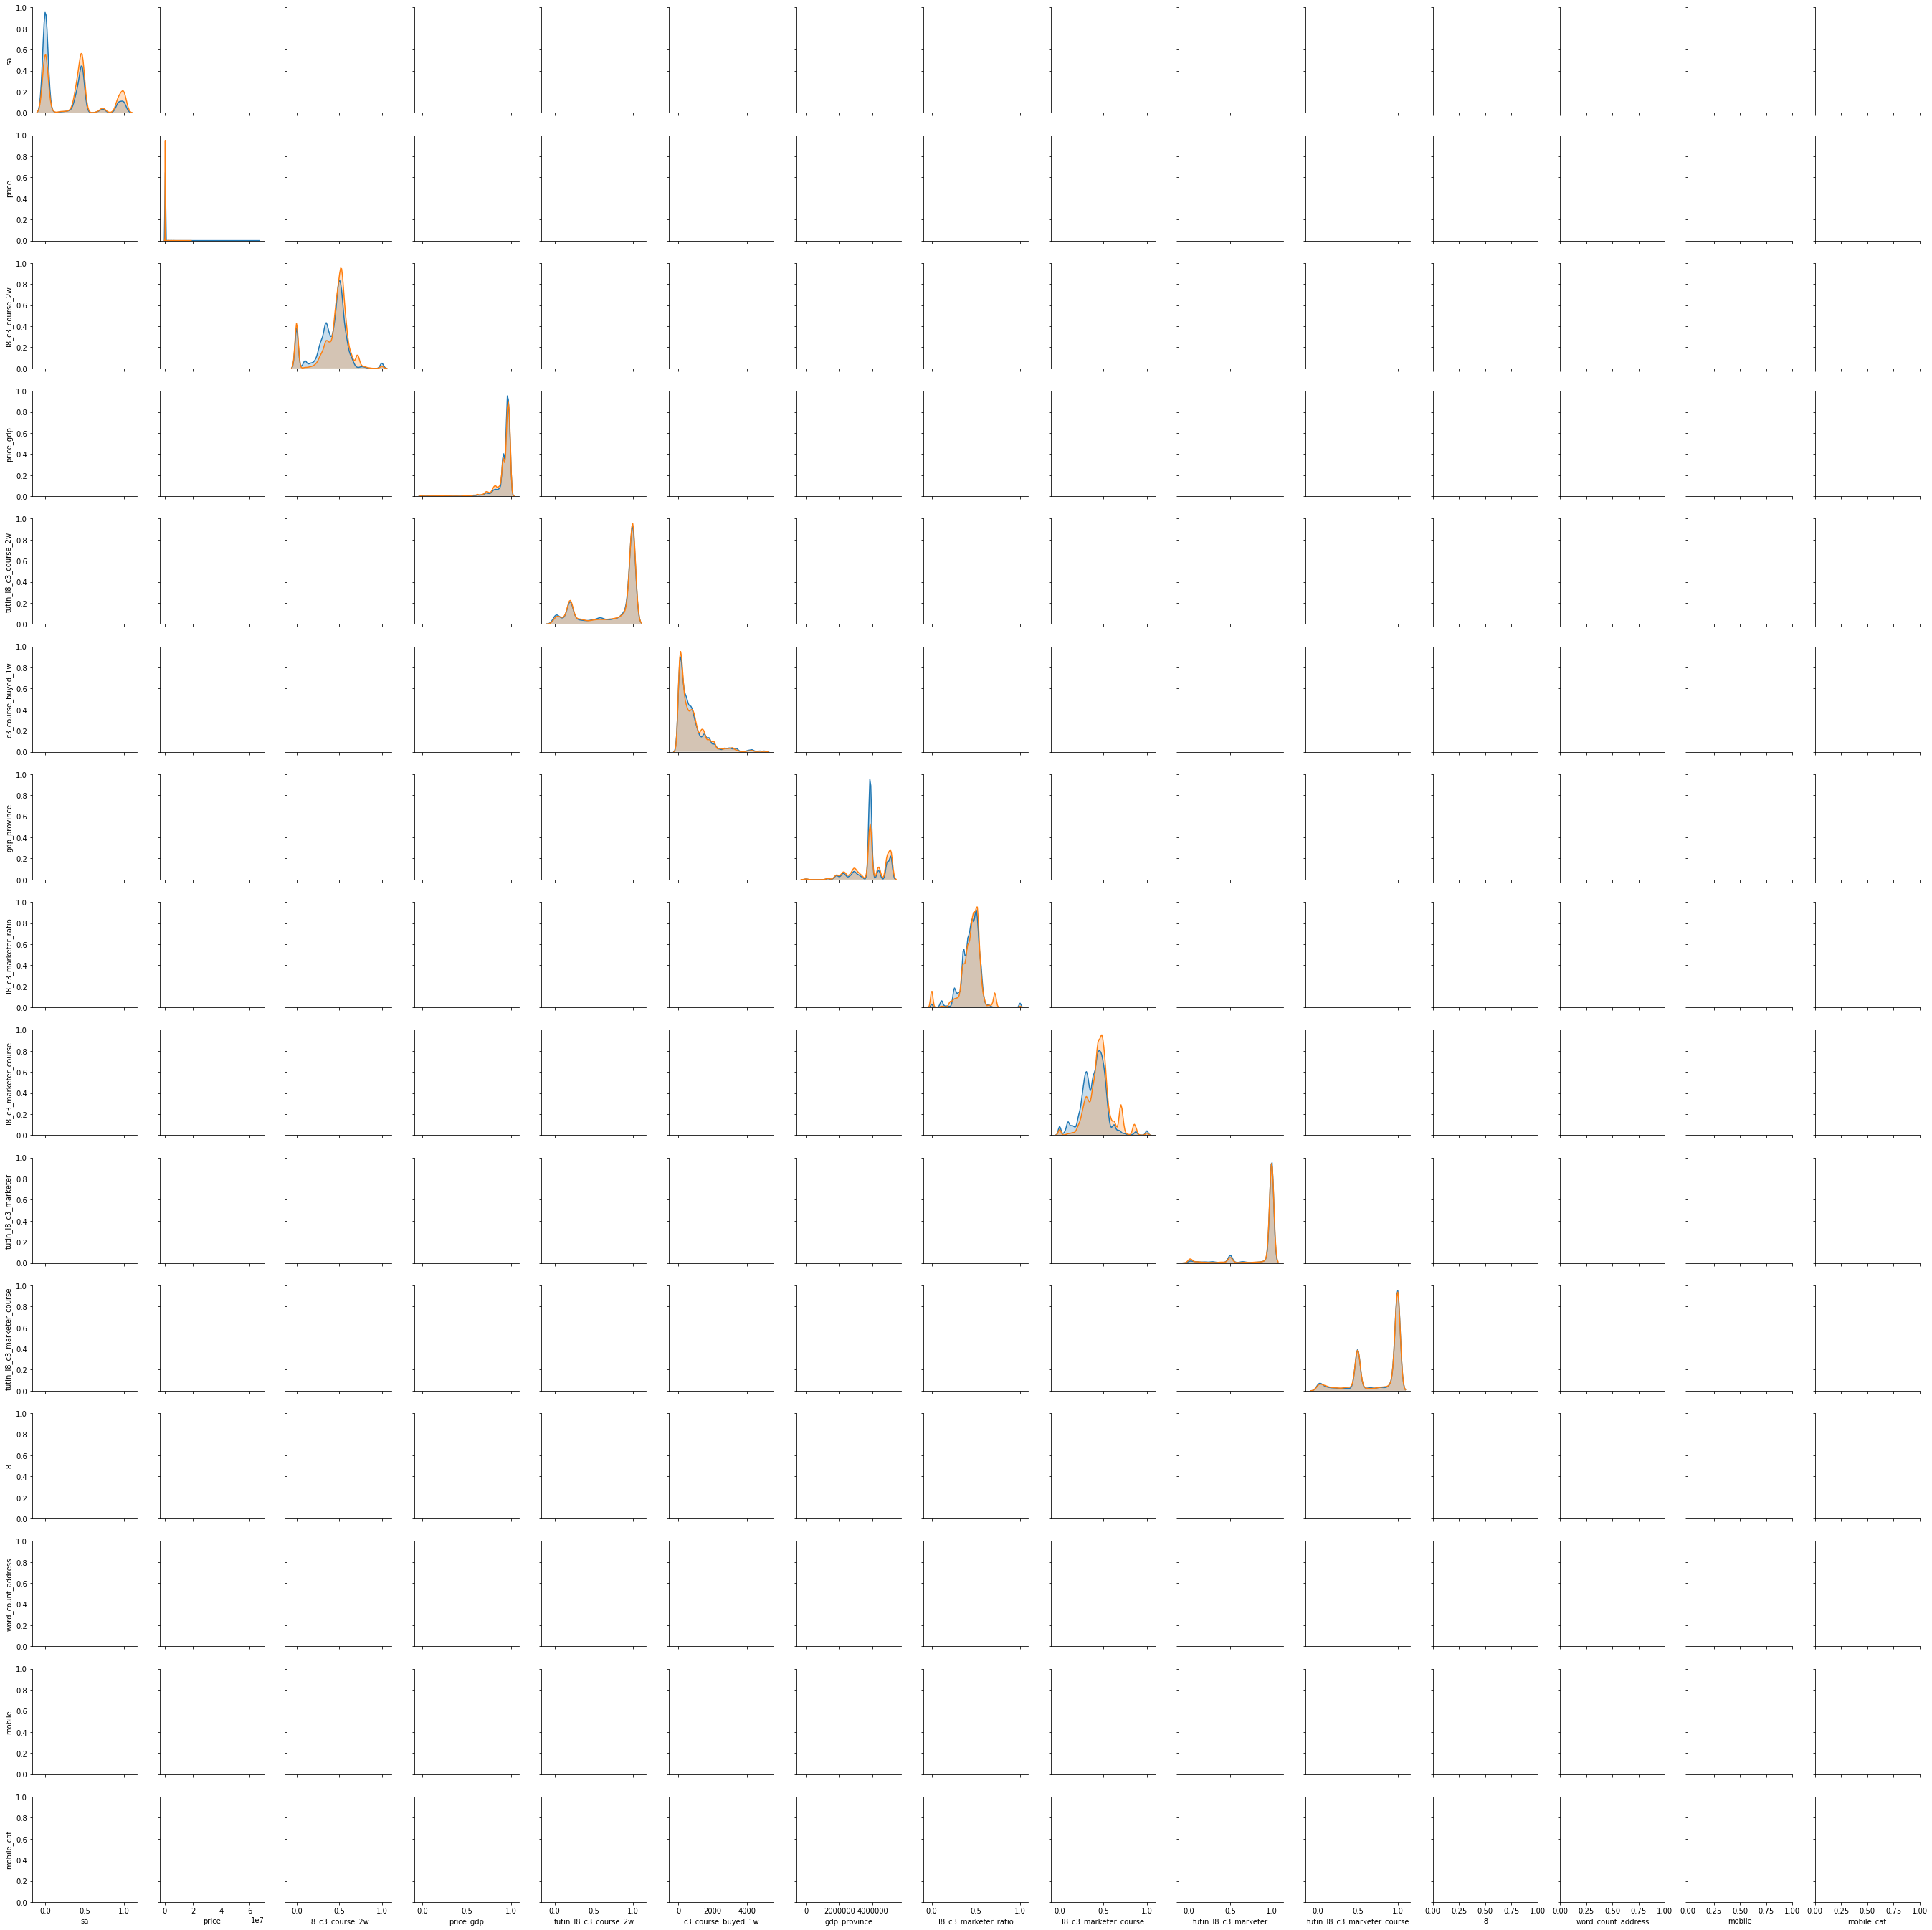

In [145]:
sns.pairplot(training, hue="l8")